**Preparing Time Series from Wide-Form Data (Core)**

You will be working with Zillow's publicly available Zillow House Value Index (ZHVI)
[https://www.zillow.com/research/data/](https://www.zillow.com/research/data/)

* Specifically, you will be using the Home Value data set for:
    * Data Type = "ZHVI All Homes (SFR+Condo/Coop) - Time Series - Smoothed - Seasonally Adjusted"
    * Geography = "City"
* We have already downloaded the file for you and uploaded it to Google Drive.
    * Share URL: [https://drive.google.com/file/d/1O_g44QAfe3uVF-1heAC0BAeVDoWloVR-/view?usp=sharing](https://drive.google.com/file/d/1O_g44QAfe3uVF-1heAC0BAeVDoWloVR-/view?usp=sharing)
    * Direct URL (for Pandas): [https://docs.google.com/spreadsheets/d/e/2PACX-1vQN3Ksa9szQuO4G1-msXWAp17KtVHQCBnuEieu_auu1wSiBf3-krHusIx5VBMkihxj-KZLBosDIGEyR/pub?output=csv](https://docs.google.com/spreadsheets/d/e/2PACX-1vQN3Ksa9szQuO4G1-msXWAp17KtVHQCBnuEieu_auu1wSiBf3-krHusIx5VBMkihxj-KZLBosDIGEyR/pub?output=csv)

**Review: Previous Assignment**

In a core assignment from last week (Preparing Time Series from Wide-Form Data (Core)), you worked with this dataset.

* You filtered the data to keep only the 4 largest cities based on their "SizeRank"
* You melted the wide-form data for the 4 largest cities into long-form time series with a datetime index.
* You resampled the data to monthly frequency, grouped by City.
* You performed EDA and answered some questions comparing the cities, including selecting the city that had the highest home value at the end of 2008 and the one that had the lowest value at the end of 2008.

# Task

**Time Series Models for Home Values**

Your overall goal is to forecast the home values for the city with the highest home value in 2008(New York) 6months into the future (beyond the dataset).

* Filter the dataset only to include values starting in 2018
* Check for and address null values.
* Decompose the Time series to detect seasonality and decide if your model should or should not have a seasonal component
* Determine Time Series Model Orders
    * Check the time series for stationarity.
        * Determine the number of differencing needed to make the data stationary
    * Check the ACF/PACF Plots of the differenced data to determine the orders
* Split the time series into training and test data (Remember we want to predict 6 months, and our data has been resampled to monthly)
* Fit a manual ARIMA/SARIMA model based on the orders determined during your exploration.
    * Make forecasts with your model.
    * Plot the forecasts versus the test data
    * Obtain metrics for evaluation
* Tune with pmdarima's auto_arima
    * Fit a model on training data with the best parameters from auto_arima
    * Obtain metrics for evaluation
    * Make forecasts with the auto_arima model
    * Plot the forecasts versus the test data
* Select your final model
* Make true future forecasts using the entire dataset (for dates beyond the entire ts).
    * Calculate the predicted net change in home value for the forecasted period as both:
        * Raw values for change in the final month in the forecast vs. the first month.
        * Convert the raw delta into a percent change.

**Answer the following questions in a Markdown cell**

* What is the predicted home value in New York City 6 months into the future (beyond the dataset)?

* What is the percent change in home values in New York City by the end of the 6-month forecast (beyond the dataset)?

# Solution

## Part 1 Prepare Time Series Wideform (Core)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set random seed
SEED = 321
np.random.seed(SEED)

In [2]:
# Customization options
# plt.style.use(['fivethirtyeight'])#'seaborn-talk'])#,
plt.rcParams['figure.facecolor']='white'
plt.rcParams['figure.figsize']=(12,4)
#import tick customization tools
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
sns.set_context("talk", font_scale=0.9)

In [3]:
def format_xdates(ax, fig=None, xtick_fontweight='bold',
               title= None):
    """Formats x-axis with minor ticks every 3 months, and major 
    ticks every year. Includes different grid options for visibility"""
    # create the locator to place ticks every 3 months.
    loc_3months = mdates.MonthLocator(interval=3)
    fmt_months = mdates.DateFormatter("%b")
    ## for major year ticks
    loc_year = mdates.YearLocator()
    fmt_year = mdates.DateFormatter("%Y")
    
    ## Change the font of the major ticks to stand out
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), 
                       fontweight=xtick_fontweight) 
    
    ## customize minor ticks
    ax.xaxis.set_minor_locator(loc_3months)
    ax.xaxis.set_minor_formatter(fmt_months)
    ## customize major ticks
    ax.xaxis.set_major_locator(loc_year)
    ax.xaxis.set_major_formatter(fmt_year)
    ## Making major/minor gridlines visually distince
    ax.grid(which='minor',axis='x',ls=":")
    ax.grid(which='major',axis='x',color='k')
    if fig is None:
        fig = ax.get_figure()
    ## rotate the dates
    fig.autofmt_xdate(which='major',rotation=90,ha='center')
    return fig,ax

In [4]:
# Load the data
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vQN3Ksa9szQuO4G1-msXWAp17KtVHQCBnuEieu_auu1wSiBf3-krHusIx5VBMkihxj-KZLBosDIGEyR/pub?output=csv"
df = pd.read_csv(url)
df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0
4,6915,4,San Antonio,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,114794.0,114975.0,...,269323.0,274032.0,278464.0,284127.0,289739.0,294776.0,297727.0,298796.0,299124.0,298951.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22462,236350,28439,Palisades,city,TX,TX,"Amarillo, TX",Randall County,NaN,NaN,...,198490.0,198467.0,196420.0,192002.0,191634.0,189383.0,191134.0,191343.0,192384.0,192110.0
22463,40403,28439,Port Mansfield,city,TX,TX,"Raymondville, TX",Willacy County,NaN,NaN,...,229251.0,232984.0,238245.0,240154.0,242470.0,243119.0,249098.0,255572.0,261910.0,264685.0
22464,54740,28439,Tribes Hill,city,NY,NY,"Amsterdam, NY",Montgomery County,53380.0,53662.0,...,132490.0,134951.0,137470.0,137430.0,137413.0,137615.0,138908.0,140096.0,141573.0,142438.0
22465,249186,28439,Derby Center,city,VT,VT,NaN,Orleans County,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,258191.0,261607.0,264571.0,266255.0


In [5]:
    # * Filter the 4 largest cities into a new dataframe.
    #     * Tip: the "SizeRank" column has already ranked the cities by size. The larger the city, the smaller the rank value.
    #         * Therefore the 4 largest cities would have rank values of [0,1,2,3]
    # So that's New York, Los Angeles, Houston, Chicago

In [6]:
df = df.loc[ df['SizeRank'] < 4 ]
df

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0


In [7]:
df.isna().sum()

RegionID      0
SizeRank      0
RegionName    0
RegionType    0
StateName     0
             ..
2022-05-31    0
2022-06-30    0
2022-07-31    0
2022-08-31    0
2022-09-30    0
Length: 281, dtype: int64

In [8]:
# convert col names into lower()
df.columns = df.columns.str.lower()
df.columns

Index(['regionid', 'sizerank', 'regionname', 'regiontype', 'statename',
       'state', 'metro', 'countyname', '2000-01-31', '2000-02-29',
       ...
       '2021-12-31', '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
       '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31', '2022-09-30'],
      dtype='object', length=281)

In [9]:
melted = pd.melt(df, id_vars=['regionid', 'sizerank', 'regionname', 'regiontype', 'statename','state', 'metro', 'countyname'])
melted

,regionid,sizerank,regionname,regiontype,statename,state,metro,countyname,variable,value
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-01-31,253690.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,2000-01-31,234181.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,2000-01-31,109068.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,2000-01-31,166139.0
4,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-02-29,255517.0
...,...,...,...,...,...,...,...,...,...,...
1087,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,2022-08-31,315587.0
1088,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2022-09-30,781622.0
1089,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,2022-09-30,966595.0
1090,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,2022-09-30,272639.0


In [10]:
melted = pd.melt(df, id_vars=['regionid', 'sizerank', 'regionname', 'regiontype', 'statename','state', 'metro', 'countyname'], var_name='date')
melted

,regionid,sizerank,regionname,regiontype,statename,state,metro,countyname,date,value
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-01-31,253690.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,2000-01-31,234181.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,2000-01-31,109068.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,2000-01-31,166139.0
4,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-02-29,255517.0
...,...,...,...,...,...,...,...,...,...,...
1087,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,2022-08-31,315587.0
1088,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2022-09-30,781622.0
1089,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,2022-09-30,966595.0
1090,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,2022-09-30,272639.0


In [11]:
# Convert the Date column to Datetime data type.
melted['date'] = pd.to_datetime(melted['date'], format='%Y-%m-%d')
melted

,regionid,sizerank,regionname,regiontype,statename,state,metro,countyname,date,value
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-01-31,253690.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,2000-01-31,234181.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,2000-01-31,109068.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,2000-01-31,166139.0
4,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-02-29,255517.0
...,...,...,...,...,...,...,...,...,...,...
1087,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,2022-08-31,315587.0
1088,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2022-09-30,781622.0
1089,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,2022-09-30,966595.0
1090,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,2022-09-30,272639.0


In [12]:
melted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   regionid    1092 non-null   int64         
 1   sizerank    1092 non-null   int64         
 2   regionname  1092 non-null   object        
 3   regiontype  1092 non-null   object        
 4   statename   1092 non-null   object        
 5   state       1092 non-null   object        
 6   metro       1092 non-null   object        
 7   countyname  1092 non-null   object        
 8   date        1092 non-null   datetime64[ns]
 9   value       1087 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 85.4+ KB


In [13]:
long_df = melted.copy()
long_df

,regionid,sizerank,regionname,regiontype,statename,state,metro,countyname,date,value
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-01-31,253690.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,2000-01-31,234181.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,2000-01-31,109068.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,2000-01-31,166139.0
4,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-02-29,255517.0
...,...,...,...,...,...,...,...,...,...,...
1087,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,2022-08-31,315587.0
1088,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2022-09-30,781622.0
1089,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,2022-09-30,966595.0
1090,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,2022-09-30,272639.0


In [14]:
# Set Date column as the index
melted = melted.set_index("date")
melted

,regionid,sizerank,regionname,regiontype,statename,state,metro,countyname,value
date,,,,,,,,,
2000-01-31,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0
2000-01-31,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0
2000-01-31,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0
2000-01-31,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0
2000-02-29,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,255517.0
...,...,...,...,...,...,...,...,...,...
2022-08-31,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,315587.0
2022-09-30,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,781622.0
2022-09-30,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,966595.0


In [15]:
# melted['value'] = melted['value'].interpolate()?
# melted['value'] = melted['value'].fillna(method='ffill')

In [16]:
melted.isna().sum()

regionid      0
sizerank      0
regionname    0
regiontype    0
statename     0
state         0
metro         0
countyname    0
value         5
dtype: int64

In [17]:
melted_drop = melted.drop(columns=['sizerank', 'regionid','statename','countyname', 'metro', 'regiontype', 'state'])
melted_drop

,regionname,value
date,,
2000-01-31,New York,253690.0
2000-01-31,Los Angeles,234181.0
2000-01-31,Houston,109068.0
2000-01-31,Chicago,166139.0
2000-02-29,New York,255517.0
...,...,...
2022-08-31,Chicago,315587.0
2022-09-30,New York,781622.0
2022-09-30,Los Angeles,966595.0


In [18]:
melted_drop.isna().sum()

regionname    0
value         5
dtype: int64

In [19]:
melted_drop

,regionname,value
date,,
2000-01-31,New York,253690.0
2000-01-31,Los Angeles,234181.0
2000-01-31,Houston,109068.0
2000-01-31,Chicago,166139.0
2000-02-29,New York,255517.0
...,...,...
2022-08-31,Chicago,315587.0
2022-09-30,New York,781622.0
2022-09-30,Los Angeles,966595.0


In [20]:
melted_drop['regionname'].nunique()

4

In [21]:
melted_drop.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1092 entries, 2000-01-31 to 2022-09-30
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   regionname  1092 non-null   object 
 1   value       1087 non-null   float64
dtypes: float64(1), object(1)
memory usage: 25.6+ KB


In [22]:
long_df = melted_drop.copy()
long_df

,regionname,value
date,,
2000-01-31,New York,253690.0
2000-01-31,Los Angeles,234181.0
2000-01-31,Houston,109068.0
2000-01-31,Chicago,166139.0
2000-02-29,New York,255517.0
...,...,...
2022-08-31,Chicago,315587.0
2022-09-30,New York,781622.0
2022-09-30,Los Angeles,966595.0


In [23]:
# Check index
long_df.index

DatetimeIndex(['2000-01-31', '2000-01-31', '2000-01-31', '2000-01-31',
               '2000-02-29', '2000-02-29', '2000-02-29', '2000-02-29',
               '2000-03-31', '2000-03-31',
               ...
               '2022-07-31', '2022-07-31', '2022-08-31', '2022-08-31',
               '2022-08-31', '2022-08-31', '2022-09-30', '2022-09-30',
               '2022-09-30', '2022-09-30'],
              dtype='datetime64[ns]', name='date', length=1092, freq=None)

In [24]:
long_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1092 entries, 2000-01-31 to 2022-09-30
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   regionname  1092 non-null   object 
 1   value       1087 non-null   float64
dtypes: float64(1), object(1)
memory usage: 25.6+ KB


In [25]:
long_df_ts = long_df.groupby('regionname').resample('M').last()['value']
long_df_ts

regionname  date      
Chicago     2000-01-31    166139.0
            2000-02-29    166536.0
            2000-03-31    167368.0
            2000-04-30    168826.0
            2000-05-31    170499.0
                            ...   
New York    2022-05-31    768797.0
            2022-06-30    773944.0
            2022-07-31    777692.0
            2022-08-31    779960.0
            2022-09-30    781622.0
Name: value, Length: 1092, dtype: float64

In [26]:
# Check type
type(long_df_ts)

pandas.core.series.Series

In [27]:
# Check index
long_df_ts.index

MultiIndex([( 'Chicago', '2000-01-31'),
            ( 'Chicago', '2000-02-29'),
            ( 'Chicago', '2000-03-31'),
            ( 'Chicago', '2000-04-30'),
            ( 'Chicago', '2000-05-31'),
            ( 'Chicago', '2000-06-30'),
            ( 'Chicago', '2000-07-31'),
            ( 'Chicago', '2000-08-31'),
            ( 'Chicago', '2000-09-30'),
            ( 'Chicago', '2000-10-31'),
            ...
            ('New York', '2021-12-31'),
            ('New York', '2022-01-31'),
            ('New York', '2022-02-28'),
            ('New York', '2022-03-31'),
            ('New York', '2022-04-30'),
            ('New York', '2022-05-31'),
            ('New York', '2022-06-30'),
            ('New York', '2022-07-31'),
            ('New York', '2022-08-31'),
            ('New York', '2022-09-30')],
           names=['regionname', 'date'], length=1092)

In [28]:
cities = ['New York', 'Los Angeles', 'Houston', 'Chicago']
cities

['New York', 'Los Angeles', 'Houston', 'Chicago']

In [29]:
plot_df = long_df_ts.loc[cities].copy()
plot_df

regionname  date      
New York    2000-01-31    253690.0
            2000-02-29    255517.0
            2000-03-31    257207.0
            2000-04-30    260310.0
            2000-05-31    263204.0
                            ...   
Chicago     2022-05-31    312487.0
            2022-06-30    314663.0
            2022-07-31    315910.0
            2022-08-31    315587.0
            2022-09-30    315429.0
Name: value, Length: 1092, dtype: float64

In [30]:
# Level 0 is regionname
plot_df.index.get_level_values(0)

Index(['New York', 'New York', 'New York', 'New York', 'New York', 'New York',
       'New York', 'New York', 'New York', 'New York',
       ...
       'Chicago', 'Chicago', 'Chicago', 'Chicago', 'Chicago', 'Chicago',
       'Chicago', 'Chicago', 'Chicago', 'Chicago'],
      dtype='object', name='regionname', length=1092)

In [31]:
# level 1 is date
plot_df.index.get_level_values(1)

DatetimeIndex(['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2021-12-31', '2022-01-31', '2022-02-28', '2022-03-31',
               '2022-04-30', '2022-05-31', '2022-06-30', '2022-07-31',
               '2022-08-31', '2022-09-30'],
              dtype='datetime64[ns]', name='date', length=1092, freq=None)

In [32]:
# Plot the home values for all 4 cities. (Hint: use unstack)
# Make sure to add a title and axis labels.
# Reformat the y-axis ticks to use thousands of dollars with a "K" at the end. (e.g. "200K, 400K, etc")
# Hint: use the FuncFormatter from matplotlib.
# Applying unstack
unstacked = plot_df.unstack(level=0)
unstacked

regionname,Chicago,Houston,Los Angeles,New York
date,,,,
2000-01-31,166139.0,109068.0,234181.0,253690.0
2000-02-29,166536.0,109079.0,234401.0,255517.0
2000-03-31,167368.0,108878.0,235513.0,257207.0
2000-04-30,168826.0,108881.0,237589.0,260310.0
2000-05-31,170499.0,108834.0,240113.0,263204.0
...,...,...,...,...
2022-05-31,312487.0,265558.0,990391.0,768797.0
2022-06-30,314663.0,268901.0,992337.0,773944.0
2022-07-31,315910.0,271059.0,992630.0,777692.0


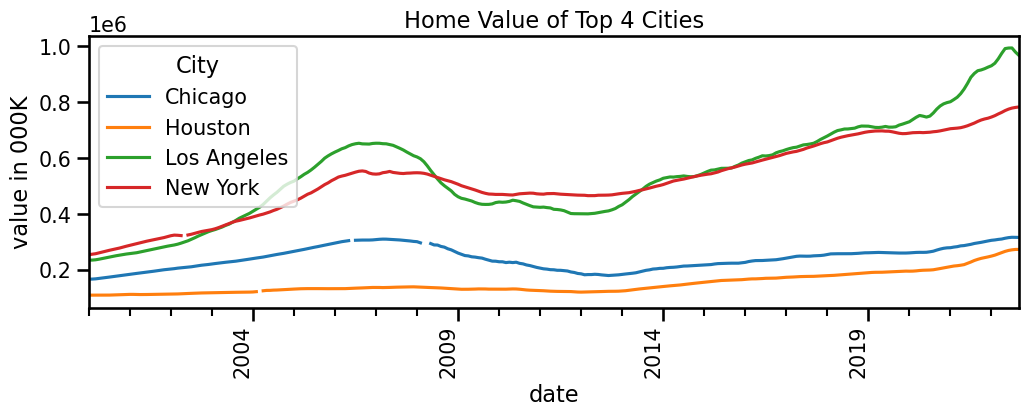

In [33]:
# Now we have the separate columns, we can plot the cities
# from matplotlib.ticker import FuncFormatter
# ax.yaxis.set_major_formatter()

ax = unstacked.plot()
ax.set_title('Home Value of Top 4 Cities')
ax.set_ylabel('value in 000K')
ax.legend(title='City')

# Customize major ticks
major_loc = mdates.YearLocator(1)
major_fmt = mdates.DateFormatter("%Y")

# Edit final xdates
fig = ax.get_figure()
fig.autofmt_xdate(which='major', rotation=90);

In [34]:
unstacked.columns

Index(['Chicago', 'Houston', 'Los Angeles', 'New York'], dtype='object', name='regionname')

**Answer the following 2 questions using pandas:**

1) Which City had the highest Typical Home Value at the end of 2008? Which had the least?
* Hint: You can use the unstacked dataframe or use pd.IndexSlice with the multiindex.

In [35]:
# Based on the graph above

# Highest = New York
# Lowest = Houston

# Checking
ch_122008 = unstacked['Chicago'].loc['2008-12-31']
hs_122008 = unstacked['Houston'].loc['2008-12-31']
la_122008 = unstacked['Los Angeles'].loc['2008-12-31']
ny_122008 = unstacked['New York'].loc['2008-12-31']

In [36]:
ch_122008

265306.0

In [37]:
hs_122008

131283.0

In [38]:
la_122008

469294.0

In [39]:
ny_122008

510309.0

2) How much did the home values change from November 2008 to December 2008 (in dollars)?
* Hint: you can use .diff() to calculate the change in values

In [40]:
# Slice out 2008
ts_112008 = unstacked.loc['2008-11-30']
ts_122008 = unstacked.loc['2008-12-31']

In [41]:
diff = ts_112008 - ts_122008
diff

# The home values changed in different rates as per below: (in dollars)

regionname
Chicago         5753.0
Houston          964.0
Los Angeles    12611.0
New York        4458.0
dtype: float64

In [42]:
# Home values changed in Chicago by $5753.
# In Houston, home values changed by $ 964.
# In Los Angeles, home values changed by $12611.
# While in New York, home values changed by $4458.

# Comparing all the four cities, the biggest change was in Los Angeles.

## Part 2 GridSearch SARIMA Models (Core)

In [43]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs
from pmdarima.model_selection import train_test_split

from sklearn import set_config
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)

import statsmodels.tsa.api as tsa

#set_config(transform_output="pandas")
plt.rcParams["figure.figsize"] = (12, 4)
sns.set_context("talk", font_scale=0.9)

# set random seed
SEED = 321
np.random.seed(SEED)

In [44]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    
### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags == None:
        n_train_lags = len(ts_train)

    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df["mean"].plot(ax=ax, color="green", label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(
        forecast_df.index,
        forecast_df["mean_ci_lower"],
        forecast_df["mean_ci_upper"],
        color="green",
        alpha=0.3,
        lw=2,
    )

    # set the title and add legend
    ax.set_title(title)
    ax.legend()

    return fig, ax

In [45]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, icbest) = tsa.adfuller(ts, **kwargs)
    
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {
        "Test Statistic": test_stat,
        "# of Lags Used": nlags,
        "# of Observations": nobs,
        "p-value": round(pval, 6),
        "alpha": alpha,
        "sig/stationary?": pval < alpha,
    }
    
    return pd.DataFrame(adfuller_results, index=[label])

In [46]:
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [47]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                  acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                  seas_color='black'):

    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    # Sig lags line style
    sig_vline_kwargs = dict(ls=":", lw=1, zorder=0, color="red")

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)

    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts, nlags=nlags, alpha=alpha, type="ACF")
        for lag in sig_acf_lags:
            axes[0].axvline(lag, label="sig", **sig_vline_kwargs)

    # PACF
    tsa.graphics.plot_pacf(ts, ax=axes[1], lags=nlags, **pacf_kws)

    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts, nlags=nlags, alpha=alpha, type="PACF")
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label="sig", **sig_vline_kwargs)

    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags // m

        # Seasonal Lines style
        seas_vline_kwargs = dict(ls="--", lw=1, alpha=0.7, color=seas_color, zorder=-1)

        ## for each season, add a line
        for i in range(1, n_seasons + 1):
            axes[0].axvline(m * i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m * i, **seas_vline_kwargs, label="season")

    fig.tight_layout()

    return fig

In [48]:
# * Filter the dataset only to include values starting in 2018
melted_ts = melted.loc['2018':'2022', ['regionid', 'sizerank', 'regionname', 'regiontype', 'statename','state', 'metro', 'countyname','value']]
melted_ts

,regionid,sizerank,regionname,regiontype,statename,state,metro,countyname,value
date,,,,,,,,,
2018-01-31,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,656700.0
2018-01-31,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,677868.0
2018-01-31,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,178763.0
2018-01-31,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,254397.0
2018-02-28,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,661012.0
...,...,...,...,...,...,...,...,...,...
2022-08-31,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,315587.0
2022-09-30,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,781622.0
2022-09-30,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,966595.0


In [49]:
long_df_ts = melted_ts.groupby('regionname').resample('M').last()['value']
long_df_ts

regionname  date      
Chicago     2018-01-31    254397.0
            2018-02-28    256564.0
            2018-03-31    256995.0
            2018-04-30    257112.0
            2018-05-31    257174.0
                            ...   
New York    2022-05-31    768797.0
            2022-06-30    773944.0
            2022-07-31    777692.0
            2022-08-31    779960.0
            2022-09-30    781622.0
Name: value, Length: 228, dtype: float64

In [50]:
# * Check for and address null values.
long_df_ts.isna().sum()

0

In [51]:
ts = melted.loc['2018':'2022', ['value']]
ts

,value
date,
2018-01-31,656700.0
2018-01-31,677868.0
2018-01-31,178763.0
2018-01-31,254397.0
2018-02-28,661012.0
...,...
2022-08-31,315587.0
2022-09-30,781622.0
2022-09-30,966595.0


In [52]:
ts = ts.resample('M').last()['value']
ts

date
2018-01-31    254397.0
2018-02-28    256564.0
2018-03-31    256995.0
2018-04-30    257112.0
2018-05-31    257174.0
2018-06-30    257461.0
2018-07-31    257467.0
2018-08-31    257258.0
2018-09-30    257917.0
2018-10-31    258549.0
2018-11-30    259637.0
2018-12-31    260447.0
2019-01-31    260559.0
2019-02-28    261069.0
2019-03-31    261214.0
2019-04-30    261813.0
2019-05-31    261519.0
2019-06-30    261110.0
2019-07-31    260676.0
2019-08-31    260236.0
2019-09-30    259915.0
2019-10-31    259593.0
2019-11-30    259510.0
2019-12-31    259625.0
2020-01-31    260161.0
2020-02-29    261128.0
2020-03-31    261799.0
2020-04-30    262116.0
2020-05-31    262013.0
2020-06-30    262362.0
2020-07-31    264051.0
2020-08-31    266204.0
2020-09-30    270202.0
2020-10-31    273716.0
2020-11-30    276541.0
2020-12-31    278154.0
2021-01-31    278668.0
2021-02-28    280878.0
2021-03-31    282423.0
2021-04-30    285237.0
2021-05-31    286248.0
2021-06-30    288347.0
2021-07-31    290773.0
2021-0

In [53]:
import matplotlib.ticker as mticks
import matplotlib.dates as mdates

def millions(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000_000
    return f"{new_x:,.0f}M"
def thousands(x,pos):
    """function for use wth matplotlib FuncFormatter -  formats money in millions"""
    new_x = x/1_000
    return f"{new_x:,.0f}K"
# Create the formatters
fmt_mill = mticks.FuncFormatter(millions)
fmt_thous = mticks.FuncFormatter(thousands)

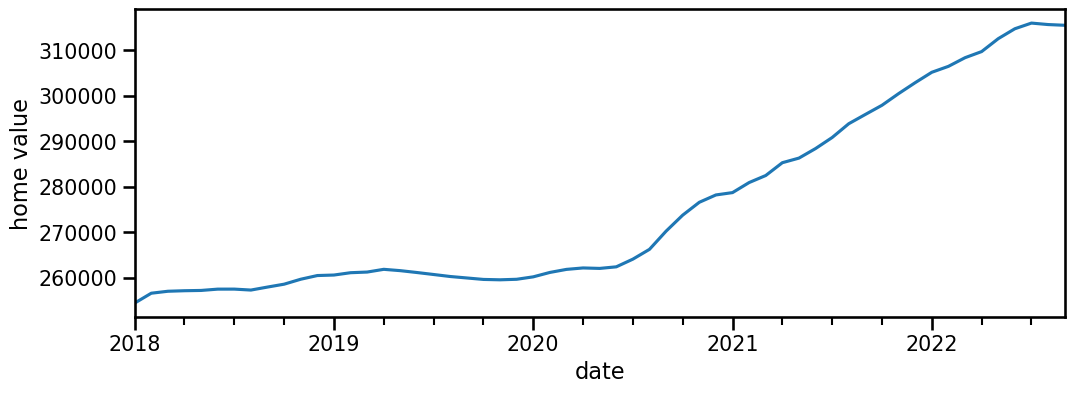

In [54]:
ax = ts.plot()
ax.set_ylabel('home value');

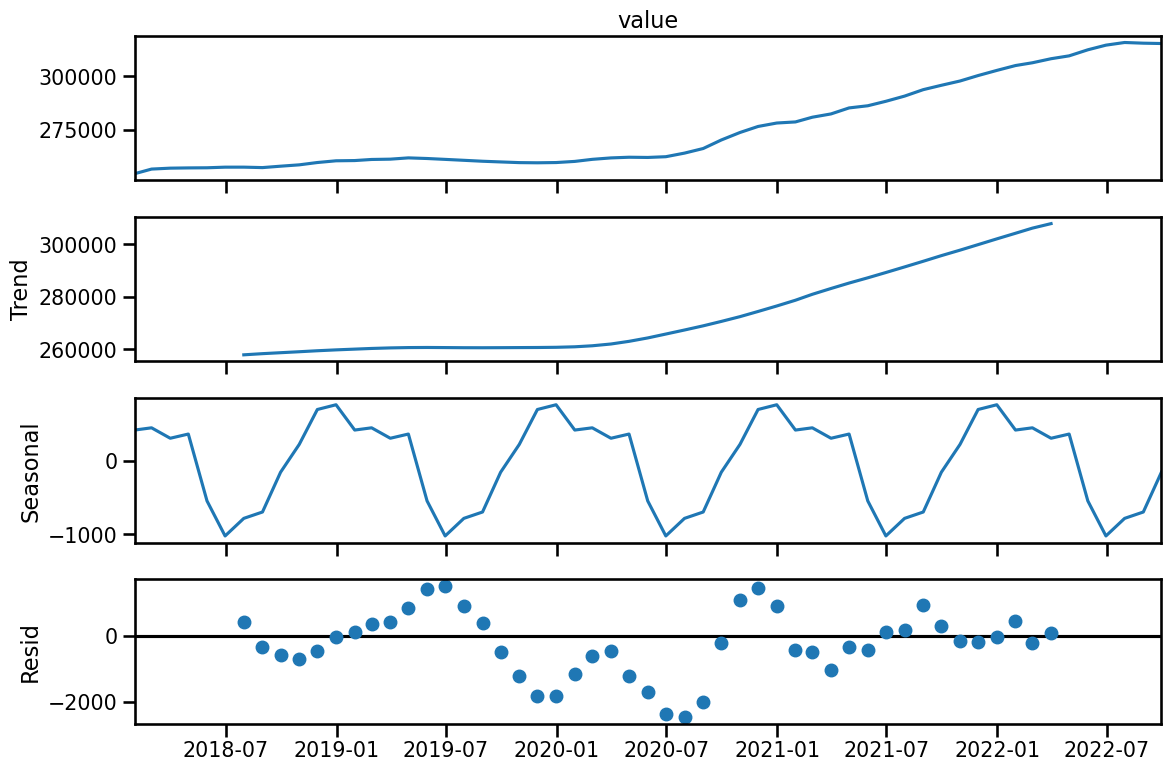

In [55]:
# Decompose the Time series to detect seasonality and decide if your model should or should not have a seasonal component

# Apply seasonal decomposition
decomp = tsa.seasonal_decompose(ts)

# plot
fig = decomp.plot()
fig.set_size_inches(12, 8)
fig.tight_layout()

# Resid = Residual = Noise

In [56]:
# How big is the seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min() 

# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta: .2f} which is ~{seasonal_delta/(ts.max()-ts.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is  1780.38 which is ~2.89% of the variation in time series.


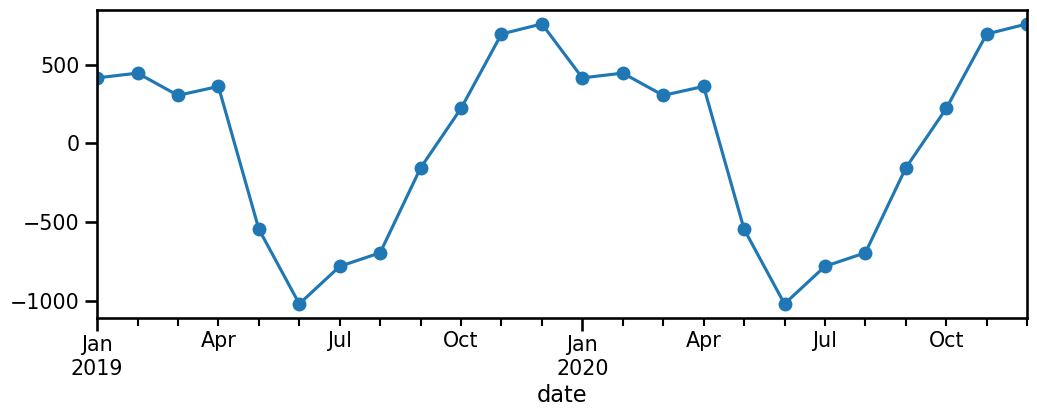

In [57]:
# Narrow down the date range of the plot
seasonal = decomp.seasonal

# plot
ax = seasonal.loc['2019':'2020'].plot(marker = 'o');

In [58]:
# * Determine Time Series Model Orders
#     * Check the time series for stationarity.
#         * Determine the number of differencing needed to make the data stationary
#     * Check the ACF/PACF Plots of the differenced data to determine the orders
# Testing the raw data for stationarity
get_adfuller_results(ts)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-0.831673,7,49,0.809641,0.05,False


In [59]:
# Data is NOT stationary

In [60]:
# use ndiffs to determine differencing (process to make the data's overall trend more stable)
# by being  stationary overtime (not moving)
# it's usually a value between 1 and 2
d = ndiffs(ts)
print(f'd = {d}')

# by making the data stable (achieving stationarity) because many time series analysis performan better when the data
# does not show strong trends or seasonality

d = 2


In [61]:
# Determine D
D = nsdiffs(ts, m = 12)   # number of points

# nsdiffs = function used to analyze ts/ timeseries for seasonal patterns (patterns are trends that repeat at regular intervals)

print (f'D = {D}')

D = 0


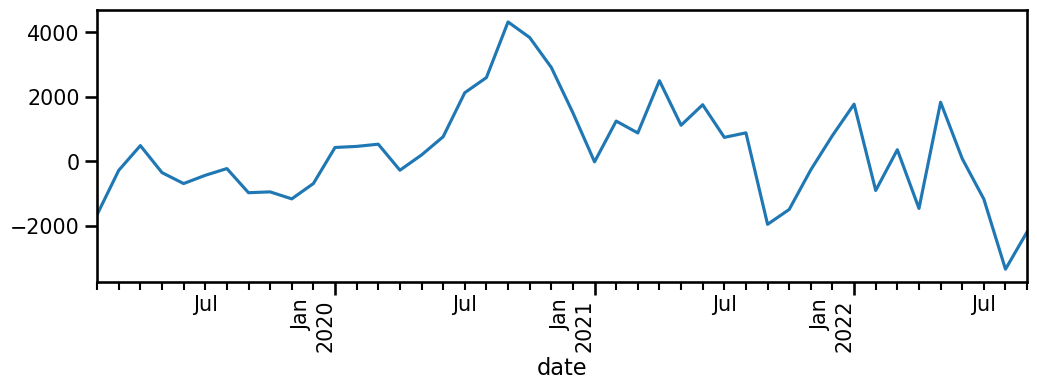

In [62]:
# apply both differencings
ts_diff = ts.diff().diff(12).dropna()

# create the plot
fig, ax = plt.subplots()
ts_diff.plot(ax = ax)

# Customize major ticks
major_loc = mdates.YearLocator(1)
major_fmt = mdates.DateFormatter("%M")

# Edit final xdates
fig = ax.get_figure()
fig.autofmt_xdate(which='major', rotation=90);

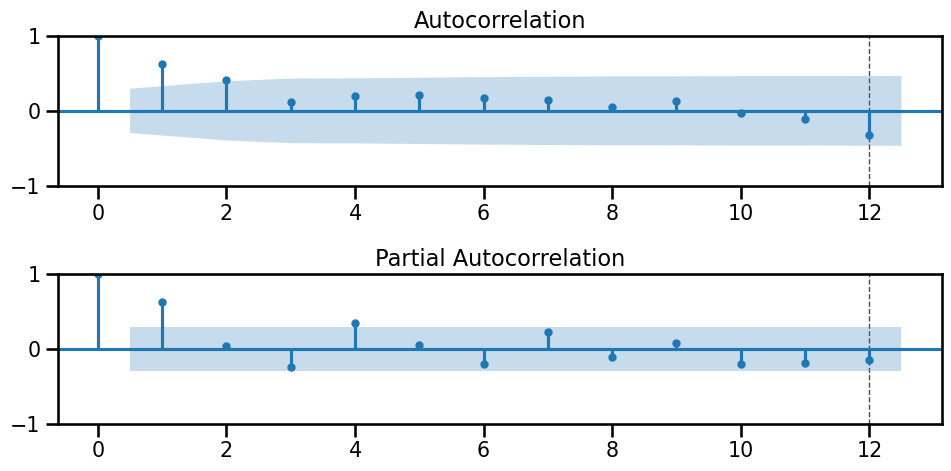

In [63]:
# Determine initial model orders

# We can use our function to highlight the seasonal lags by adding the arguments, plot ACF PACF
# plot differenced data (ACF autocorrelation PACF partial autocorrelation function)

# Use the ACF and PACF plots of stationarity data to estimate initial orders
plot_acf_pacf(ts_diff,
              annotate_seas = True,
              m=12,
              nlags=12, # next 12 months
              pacf_kws = {'method':'ywm'});

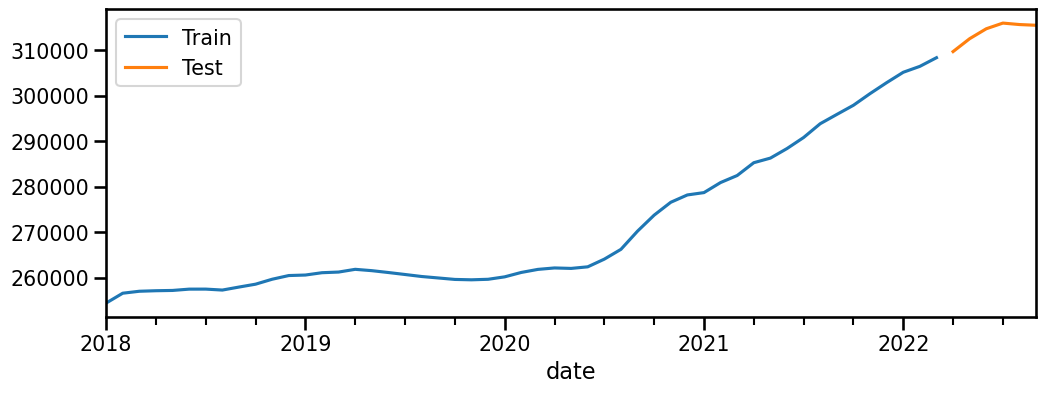

In [64]:
# * Split the time series into training and test data (Remember we want to predict 6 months, and our data has been resampled to monthly)

# tts--goal is to predict next 6 months so use 6
nlags = 6  # This is for the next 6 months
#  t-1, t-2 etc

train, test = train_test_split(ts, test_size = nlags)

# plot
ax = train.plot(label = 'Train')
test.plot(label = 'Test')
ax.legend();

In [65]:
# * Fit a manual ARIMA/SARIMA model based on the orders determined during your exploration.
#     * Make forecasts with your model.
#     * Plot the forecasts versus the test data
#     * Obtain metrics for evaluation

# Initial model

# Orders for non seasonal components
p = 2   # nonseasonal AR
d = 2  # nonseasonal differencing
q = 0  # nonseasonal MA

# Orders for seasonal components
P = 0  # Seasonal AR
D = 0  # Seasonal differencing
Q = 0  # Seasonal MA
m = 12  # Seasonal period

model_1 = tsa.ARIMA(train, order = (p, d, q), seasonal_order = (P, D, Q, m)).fit()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 1,369.705
- MSE = 4,157,253.607
- RMSE = 2,038.934
- R^2 = 0.165
- MAPE = 0.43%


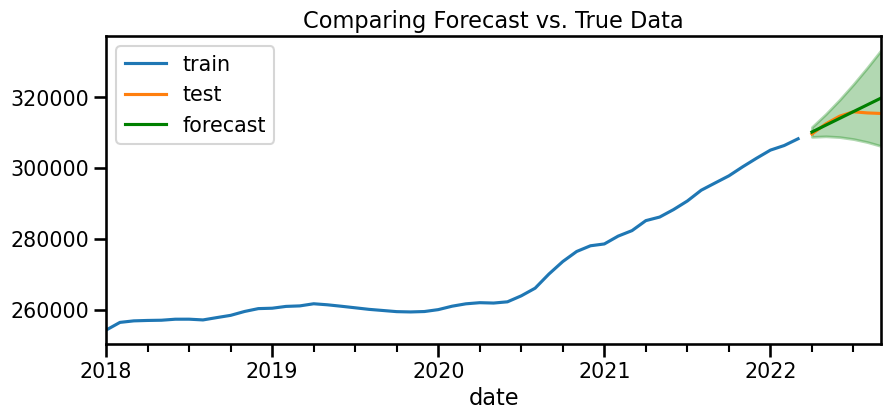

In [66]:
# Obtain summary of forecast as dataframe
forecast_df = model_1.get_forecast(len(test)).summary_frame()

# Plot the forecast with true values
plot_forecast(train, test, forecast_df)

# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

# MAPE < 5% excellent, 5-10% very good, 10-20% good, 20-50% fair, >50% bad

In [67]:
# Obtain summary
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   51
Model:                 ARIMA(2, 2, 0)   Log Likelihood                -392.169
Date:                Sun, 07 Apr 2024   AIC                            790.338
Time:                        01:58:02   BIC                            796.013
Sample:                    01-31-2018   HQIC                           792.491
                         - 03-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0257      0.067      0.383      0.702      -0.106       0.157
ar.L2          0.0046      0.090      0.051      0.959      -0.172       0.181
sigma2      4.995e+05   9.27e+04      5.388      0.000    3.18e+05    6.81e+05
===================================================================================
Ljung-Box (L1) (Q):                   3.37   Jarque-Bera (JB):                 0.68
Prob(Q):                              0.07   Prob(JB):                         0.71
Heteroskedasticity (H):               5.03   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

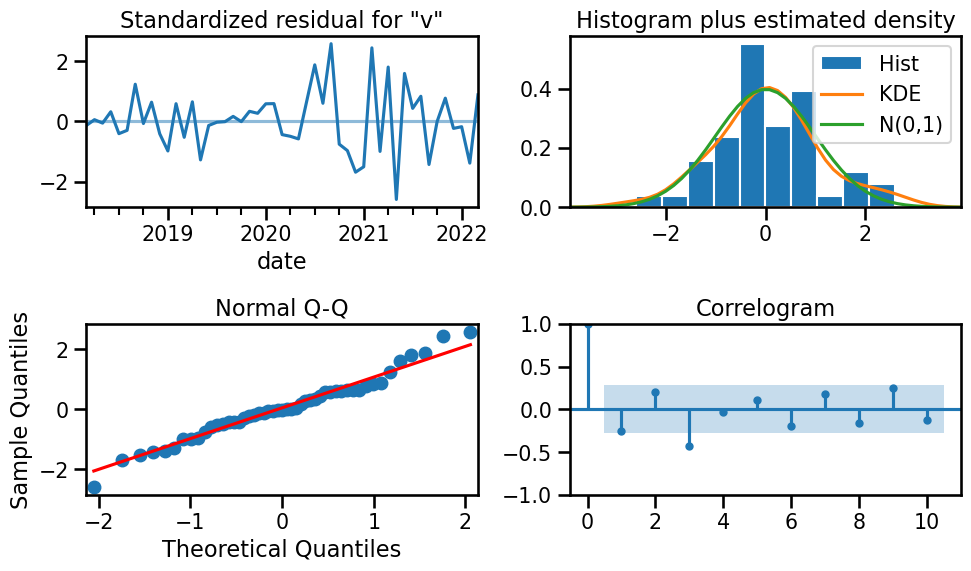

In [68]:
# Obtain diagnostic plots
fig = model_1.plot_diagnostics()
fig.set_size_inches(10, 6)
fig.tight_layout();

In [69]:
# * Tune with pmdarima's auto_arima
#     * Fit a model on training data with the best parameters from auto_arima
#     * Obtain metrics for evaluation
#     * Make forecasts with the auto_arima model
#     * Plot the forecasts versus the test data
# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(train,
                          seasonal = True,
                           m = 12,
                           trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12]             : AIC=796.074, Time=0.40 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=791.421, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=789.687, Time=0.02 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=789.791, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=788.485, Time=0.01 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=789.682, Time=0.02 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=790.170, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[12]             : AIC=790.338, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=790.300, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=788.549, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=793.086, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[12] intercept   : AIC=790.408, Time=0.02 sec

Best model:  ARIMA(1,2,0)(0,0,0)[12]          
Total fit time: 0.745 seconds


In [70]:
# the auto_arima will store our best nonseasonal and seasonal orders separtely
print(auto_model.order)
print(auto_model.seasonal_order)

(1, 2, 0)
(0, 0, 0, 12)


In [71]:
# Obtain summary of the best model from auto_arima
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   51
Model:               SARIMAX(1, 2, 0)   Log Likelihood                -392.243
Date:                Sun, 07 Apr 2024   AIC                            788.485
Time:                        01:58:04   BIC                            792.269
Sample:                    01-31-2018   HQIC                           789.921
                         - 03-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0240      0.071      0.340      0.734      -0.114       0.162
sigma2      5.104e+05   9.36e+04      5.450      0.000    3.27e+05    6.94e+05
===================================================================================
Ljung-Box (L1) (Q):                   3.31   Jarque-Bera (JB):                 0.72
Prob(Q):                              0.07   Prob(JB):                         0.70
Heteroskedasticity (H):               4.92   Skew:                             0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

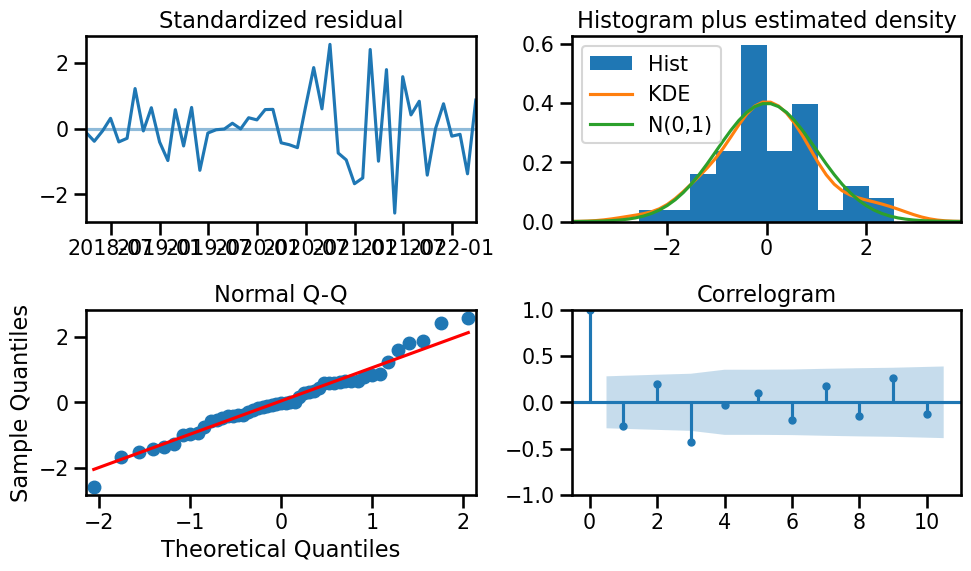

In [72]:
# Obtain diagnostic plots
fig = auto_model.plot_diagnostics()
fig.set_size_inches(10, 6)
fig.tight_layout();

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 1,371.919
- MSE = 4,171,518.606
- RMSE = 2,042.430
- R^2 = 0.162
- MAPE = 0.44%


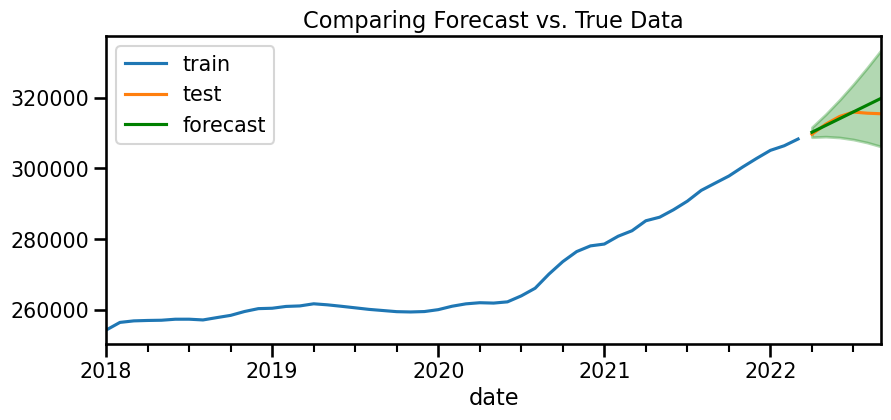

In [73]:
# Use auto_arima parameters to fit an ARIMA
model_2 = tsa.ARIMA(train, order = auto_model.order,
                   seasonal_order = auto_model.seasonal_order).fit()

# Obtain forecast as a dataframe with confidence intervals
forecast_df = model_2.get_forecast(steps = len(test)).summary_frame()

# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df)

# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

In [74]:
ts_all = melted.loc['2000':'2022', ['value']]
ts_all

,value
date,
2000-01-31,253690.0
2000-01-31,234181.0
2000-01-31,109068.0
2000-01-31,166139.0
2000-02-29,255517.0
...,...
2022-08-31,315587.0
2022-09-30,781622.0
2022-09-30,966595.0


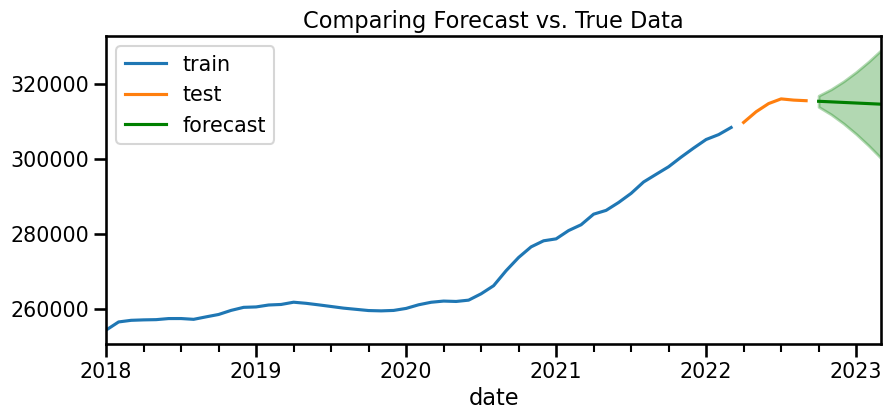

In [78]:
# Use auto_arima parameters to fit an ARIMA
final_model = tsa.ARIMA(ts,
                        order = auto_model.order,
                        seasonal_order = auto_model.seasonal_order).fit()

# Obtain future forecasts beyond test data
forecast_df = final_model.get_forecast(len(test)).summary_frame()
plot_forecast(train, test, forecast_df, n_train_lags = 60);

In [56]:
# * Select your final model
# * Make true future forecasts using the entire dataset (for dates beyond the entire ts).
#     * Calculate the predicted net change in home value for the forecasted period as both:
#         * Raw values for change in the final month in the forecast vs. the first month.
#         * Convert the raw delta into a percent change.

In [79]:
# Forecast mean:
forecast_df['mean']

2022-10-31    315274.701796
2022-11-30    315120.486643
2022-12-31    314966.273353
2023-01-31    314812.060105
2023-02-28    314657.846857
2023-03-31    314503.633610
Freq: M, Name: mean, dtype: float64

In [80]:
# Month with Maximum forecasted for next year
forecast_df['mean'].idxmax()

Timestamp('2022-10-31 00:00:00', freq='M')

In [81]:
# Month with Minimum next year
forecast_df['mean'].idxmin()

Timestamp('2023-03-31 00:00:00', freq='M')

In [82]:
forecast_df.index[0],forecast_df.index[-1]

(Timestamp('2022-10-31 00:00:00', freq='M'),
 Timestamp('2023-03-31 00:00:00', freq='M'))

In [83]:
# Define the starting value
starting_value = forecast_df['mean'].iloc[0]
starting_value

315274.7017963432

In [84]:
final_value = forecast_df['mean'].iloc[-1]
final_value

314503.6336097364

In [85]:
# Calculating the 
change = final_value - starting_value
change

-771.0681866068044

In [86]:
# The percent change over the 12-month forecast
perc_change = (change / starting_value) * 100
perc_change

-0.24457026910611065